In [119]:
import os
import sys
import gc
import glob
import time
from os import listdir

import tqdm
from typing import Dict

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

import numpy as np
import pandas as pd


In [120]:
folder_path = '/Users/hesu/Documents/KT/riiid/'
train_csv = folder_path + 'train.csv'
test_csv =  folder_path + 'example_test.csv'
lec_csv  =  folder_path + 'lectures.csv'
que_csv =   folder_path + 'questions.csv'
sample_csv =    folder_path + 'example_sample_submission.csv'

data_types_dict = {
    'row_id': 'int64',
    'timestamp': 'int64',
    'user_id': 'int32',
    'content_id': 'int32',
    'content_type_id': 'int8',
    'task_container_id': 'int16',
     'user_answer': 'int8',
    'answered_correctly': 'int8',
    'prior_question_elapsed_time': 'float',
    'prior_question_had_explanation': 'boolean'
}

In [121]:
train_df = pd.read_csv(train_csv, 
                       nrows=1000000)

question_df = pd.read_csv(que_csv)


In [122]:
train_df = pd.merge(train_df, question_df, left_on='content_id', right_on='question_id',how='left')

In [123]:
train_df.head(10)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,bundle_id,correct_answer,part,tags
0,0,0,115,5692,0,1,3,1,NaN,NaN,5692.0,5692.0,3.0,5.0,151
1,1,56943,115,5716,0,2,2,1,37000.0,False,5716.0,5716.0,2.0,5.0,168
2,2,118363,115,128,0,0,0,1,55000.0,False,128.0,128.0,0.0,1.0,131 149 92
3,3,131167,115,7860,0,3,0,1,19000.0,False,7860.0,7860.0,0.0,1.0,131 104 81
4,4,137965,115,7922,0,4,1,1,11000.0,False,7922.0,7922.0,1.0,1.0,131 149 92
5,5,157063,115,156,0,5,2,1,5000.0,False,156.0,156.0,2.0,1.0,131 101 162 38
6,6,176092,115,51,0,6,0,1,17000.0,False,51.0,51.0,0.0,1.0,131 187 81
7,7,194190,115,50,0,7,3,1,17000.0,False,50.0,50.0,3.0,1.0,131 101 38
8,8,212463,115,7896,0,8,2,1,16000.0,False,7896.0,7896.0,2.0,1.0,131 104 162 81
9,9,230983,115,7863,0,9,0,1,16000.0,False,7863.0,7863.0,0.0,1.0,131 68 92


In [124]:
len(train_df)

1000000

In [125]:
train_df.drop(['content_id'], axis=1)

,row_id,timestamp,user_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,bundle_id,correct_answer,part,tags
0,0,0,115,0,1,3,1,NaN,NaN,5692.0,5692.0,3.0,5.0,151
1,1,56943,115,0,2,2,1,37000.0,False,5716.0,5716.0,2.0,5.0,168
2,2,118363,115,0,0,0,1,55000.0,False,128.0,128.0,0.0,1.0,131 149 92
3,3,131167,115,0,3,0,1,19000.0,False,7860.0,7860.0,0.0,1.0,131 104 81
4,4,137965,115,0,4,1,1,11000.0,False,7922.0,7922.0,1.0,1.0,131 149 92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,999995,26482248,20949024,0,29,1,1,14000.0,True,8803.0,8803.0,1.0,5.0,170
999996,999996,26516686,20949024,0,30,3,1,17000.0,True,4664.0,4664.0,3.0,5.0,34
999997,999997,26537967,20949024,0,31,1,0,18000.0,True,4108.0,4108.0,0.0,5.0,23
999998,999998,26590240,20949024,0,32,3,0,6000.0,True,5014.0,5014.0,0.0,5.0,181


In [126]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 15 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   row_id                          1000000 non-null  int64  
 1   timestamp                       1000000 non-null  int64  
 2   user_id                         1000000 non-null  int64  
 3   content_id                      1000000 non-null  int64  
 4   content_type_id                 1000000 non-null  int64  
 5   task_container_id               1000000 non-null  int64  
 6   user_answer                     1000000 non-null  int64  
 7   answered_correctly              1000000 non-null  int64  
 8   prior_question_elapsed_time     976277 non-null   float64
 9   prior_question_had_explanation  996184 non-null   object 
 10  question_id                     987816 non-null   float64
 11  bundle_id                       987816 non-null   float64
 12  c

In [127]:
def convert_bool(col): 
    if str(col) == "true": 
       return True 
    elif str(col) == "false": 
       return False 

df = pd.read_csv(train_csv,nrows=1000, converters={"prior_question_had_explanation": lambda x:convert_bool(x)})

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   row_id                          1000 non-null   int64  
 1   timestamp                       1000 non-null   int64  
 2   user_id                         1000 non-null   int64  
 3   content_id                      1000 non-null   int64  
 4   content_type_id                 1000 non-null   int64  
 5   task_container_id               1000 non-null   int64  
 6   user_answer                     1000 non-null   int64  
 7   answered_correctly              1000 non-null   int64  
 8   prior_question_elapsed_time     974 non-null    float64
 9   prior_question_had_explanation  0 non-null      object 
dtypes: float64(1), int64(8), object(1)
memory usage: 78.2+ KB


In [129]:
train_df = train_df[train_df.content_type_id==False]
train_df = train_df.sort_values(['timestamp'], ascending=True).reset_index(drop=True)
train_df.head(10)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,bundle_id,correct_answer,part,tags
0,0,0,115,5692,0,1,3,1,NaN,NaN,5692.0,5692.0,3.0,5.0,151
1,924336,0,19437777,7900,0,0,0,1,NaN,NaN,7900.0,7900.0,0.0,1.0,131 93 81
2,722435,0,15244238,4356,0,0,1,1,NaN,NaN,4356.0,4356.0,1.0,5.0,14
3,722405,0,15240250,7900,0,0,2,0,NaN,NaN,7900.0,7900.0,0.0,1.0,131 93 81
4,32725,0,786789,7900,0,0,0,1,NaN,NaN,7900.0,7900.0,0.0,1.0,131 93 81
5,403313,0,7872136,7900,0,0,0,1,NaN,NaN,7900.0,7900.0,0.0,1.0,131 93 81
6,403383,0,7876172,7900,0,0,0,1,NaN,NaN,7900.0,7900.0,0.0,1.0,131 93 81
7,32777,0,800824,5346,0,0,3,0,NaN,NaN,5346.0,5346.0,1.0,5.0,55
8,722064,0,15238770,7900,0,0,1,0,NaN,NaN,7900.0,7900.0,0.0,1.0,131 93 81
9,171161,0,3646751,8494,0,0,2,0,NaN,NaN,8494.0,8494.0,1.0,5.0,108


In [130]:
len(train_df)


980093

In [131]:
result_user = train_df.groupby(['user_id'])

In [132]:
result_user.head(10)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,bundle_id,correct_answer,part,tags
0,0,0,115,5692,0,1,3,1,NaN,NaN,5692.0,5692.0,3.0,5.0,151
1,924336,0,19437777,7900,0,0,0,1,NaN,NaN,7900.0,7900.0,0.0,1.0,131 93 81
2,722435,0,15244238,4356,0,0,1,1,NaN,NaN,4356.0,4356.0,1.0,5.0,14
3,722405,0,15240250,7900,0,0,2,0,NaN,NaN,7900.0,7900.0,0.0,1.0,131 93 81
4,32725,0,786789,7900,0,0,0,1,NaN,NaN,7900.0,7900.0,0.0,1.0,131 93 81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977101,400049,62031088497,7792299,2065,0,4,2,1,21000.0,False,2065.0,2063.0,2.0,3.0,136 162 92 29
977102,400050,62031088497,7792299,2063,0,4,1,0,21000.0,False,2063.0,2063.0,0.0,3.0,136 92 29
977103,400051,62031110815,7792299,6163,0,5,1,0,43666.0,False,6163.0,6163.0,2.0,5.0,96
977104,400052,62031126813,7792299,11418,0,6,3,1,20000.0,False,11418.0,11418.0,3.0,5.0,1


In [133]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980093 entries, 0 to 980092
Data columns (total 15 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   row_id                          980093 non-null  int64  
 1   timestamp                       980093 non-null  int64  
 2   user_id                         980093 non-null  int64  
 3   content_id                      980093 non-null  int64  
 4   content_type_id                 980093 non-null  int64  
 5   task_container_id               980093 non-null  int64  
 6   user_answer                     980093 non-null  int64  
 7   answered_correctly              980093 non-null  int64  
 8   prior_question_elapsed_time     976277 non-null  float64
 9   prior_question_had_explanation  976277 non-null  object 
 10  question_id                     980093 non-null  float64
 11  bundle_id                       980093 non-null  float64
 12  correct_answer  

In [134]:
train_df["content_id"] = train_df["content_id"].astype('str')
train_df["prior_question_elapsed_time"] = train_df["prior_question_elapsed_time"].astype('str')
train_df["prior_question_had_explanation"] = train_df["prior_question_had_explanation"].astype('str')
train_df["part"] = train_df["part"].astype('str')


In [135]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980093 entries, 0 to 980092
Data columns (total 15 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   row_id                          980093 non-null  int64  
 1   timestamp                       980093 non-null  int64  
 2   user_id                         980093 non-null  int64  
 3   content_id                      980093 non-null  object 
 4   content_type_id                 980093 non-null  int64  
 5   task_container_id               980093 non-null  int64  
 6   user_answer                     980093 non-null  int64  
 7   answered_correctly              980093 non-null  int64  
 8   prior_question_elapsed_time     980093 non-null  object 
 9   prior_question_had_explanation  980093 non-null  object 
 10  question_id                     980093 non-null  float64
 11  bundle_id                       980093 non-null  float64
 12  correct_answer  

In [136]:
result_user2 = train_df.groupby(by='user_id').apply(lambda x:[','.join(x['content_id'])])

In [137]:
result_user2.head(10)

user_id
115      [5692,5716,128,7860,7922,156,51,50,7896,7863,1...
124      [7900,7876,175,1278,2063,2064,2065,3364,3365,3...
2746     [5273,758,5976,236,404,382,405,873,531,775,294...
5382     [5000,3944,217,5844,5965,4990,5235,6050,5721,5...
8623     [3915,4750,6456,3968,6104,5738,6435,5498,6102,...
8701     [3901,6671,4963,6143,8279,3964,4002,754,1110,7...
12741    [5145,9691,9697,5202,4787,5695,7858,5653,5889,...
13134    [3926,564,3865,4231,3684,3988,3968,5219,4447,6...
24418    [7900,7876,175,1278,2063,2064,2065,3363,3365,3...
24600    [7900,7876,175,1278,2063,2064,2065,3365,3363,3...
dtype: object

In [138]:
len(result_user2)

3824

In [139]:
 train_df["answered_correctly"] = train_df["answered_correctly"].astype('str')

In [140]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980093 entries, 0 to 980092
Data columns (total 15 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   row_id                          980093 non-null  int64  
 1   timestamp                       980093 non-null  int64  
 2   user_id                         980093 non-null  int64  
 3   content_id                      980093 non-null  object 
 4   content_type_id                 980093 non-null  int64  
 5   task_container_id               980093 non-null  int64  
 6   user_answer                     980093 non-null  int64  
 7   answered_correctly              980093 non-null  object 
 8   prior_question_elapsed_time     980093 non-null  object 
 9   prior_question_had_explanation  980093 non-null  object 
 10  question_id                     980093 non-null  float64
 11  bundle_id                       980093 non-null  float64
 12  correct_answer  

In [141]:
result_user3 =  train_df.groupby(by='user_id')

In [142]:
combine = result_user3.agg({'content_id':','.join, 'answered_correctly':','.join,'part':','.join,
                            'prior_question_elapsed_time':','.join})

In [150]:
combine.columns = ['all_content_id','all_answer','all_part','all_prior_elapsed']

In [151]:
len(combine)

3824

In [153]:
combine.head(10)

,all_content_id,all_answer,all_part,all_prior_elapsed
user_id,,,,
115,"5692,5716,128,7860,7922,156,51,50,7896,7863,15...","1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,1,0,1,1,0,0,0,...","5.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1....","nan,37000.0,55000.0,19000.0,11000.0,5000.0,170..."
124,"7900,7876,175,1278,2063,2064,2065,3364,3365,33...","1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,...","1.0,1.0,1.0,2.0,3.0,3.0,3.0,4.0,4.0,4.0,4.0,4....","nan,26000.0,29000.0,26000.0,18000.0,18000.0,18..."
2746,"5273,758,5976,236,404,382,405,873,531,775,294,...","0,0,0,1,0,1,1,1,1,0,1,1,0,1,0,1,1,0,1","5.0,2.0,5.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2....","nan,28000.0,17000.0,24000.0,20000.0,16000.0,16..."
5382,"5000,3944,217,5844,5965,4990,5235,6050,5721,55...","1,0,1,0,1,1,1,1,0,0,0,1,0,1,1,1,1,0,1,1,0,0,0,...","5.0,5.0,2.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,1....","nan,24000.0,35000.0,88000.0,18000.0,12000.0,50..."
8623,"3915,4750,6456,3968,6104,5738,6435,5498,6102,4...","1,1,1,1,1,1,1,0,0,1,1,0,0,1,1,0,1,1,1,0,0,1,1,...","5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,2....","nan,16000.0,33000.0,30000.0,40000.0,35000.0,30..."
8701,"3901,6671,4963,6143,8279,3964,4002,754,1110,77...","1,1,1,0,1,0,0,0,1,0,0,1,1,1,0,1,1","5.0,5.0,5.0,5.0,5.0,5.0,5.0,2.0,2.0,2.0,2.0,2....","nan,13000.0,15000.0,24000.0,25000.0,44000.0,17..."
12741,"5145,9691,9697,5202,4787,5695,7858,5653,5889,4...","0,1,0,1,1,0,1,0,1,0,0,1,0,1,1,0,0,1,0,1,0,0,1,...","5.0,5.0,5.0,5.0,5.0,5.0,1.0,5.0,5.0,5.0,5.0,6....","nan,13000.0,18000.0,29000.0,35000.0,15000.0,21..."
13134,"3926,564,3865,4231,3684,3988,3968,5219,4447,61...","1,0,0,1,1,0,0,1,1,0,1,1,1,0,1,1,0,1,0,1,0,1,1,...","5.0,2.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5....","nan,22000.0,18000.0,19000.0,13000.0,43000.0,65..."
24418,"7900,7876,175,1278,2063,2064,2065,3363,3365,33...","0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,1,...","1.0,1.0,1.0,2.0,3.0,3.0,3.0,4.0,4.0,4.0,4.0,4....","nan,30000.0,20000.0,24000.0,17000.0,17000.0,17..."


In [154]:
train_df = pd.merge(train_df, combine, left_on='user_id',right_on='user_id',how='left')

In [155]:
train_df.head(10)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly_x,prior_question_elapsed_time_x,prior_question_had_explanation,...,correct_answer,part_x,tags,answered_correctly_y,part_y,prior_question_elapsed_time_y,all_content_id,all_answer,all_part,all_prior_elapsed
0,0,0,115,5692,0,1,3,1,nan,nan,...,3.0,5.0,151,NaN,NaN,NaN,"5692,5716,128,7860,7922,156,51,50,7896,7863,15...","1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,1,0,1,1,0,0,0,...","5.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1....","nan,37000.0,55000.0,19000.0,11000.0,5000.0,170..."
1,924336,0,19437777,7900,0,0,0,1,nan,nan,...,0.0,1.0,131 93 81,NaN,NaN,NaN,"7900,7876,175,1278,2065,2063,2064,3365,3363,33...","1,0,1,1,1,0,1,1,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0,...","1.0,1.0,1.0,2.0,3.0,3.0,3.0,4.0,4.0,4.0,4.0,4....","nan,20000.0,23000.0,40000.0,16000.0,16000.0,16..."
2,722435,0,15244238,4356,0,0,1,1,nan,nan,...,1.0,5.0,14,NaN,NaN,NaN,"4356,3655,3917,4535,4503,3658,4957,6842,6843,6...","1,1,0,0,0,0,0,0,1,1,0,0,1,1,1,0,1,0,1,1,1,0,1,...","5.0,5.0,5.0,5.0,5.0,5.0,5.0,6.0,6.0,6.0,6.0,5....","nan,21000.0,17000.0,25000.0,30000.0,19000.0,15..."
3,722405,0,15240250,7900,0,0,2,0,nan,nan,...,0.0,1.0,131 93 81,NaN,NaN,NaN,"7900,7876,175,1278,2065,2064,2063,3365,3363,33...","0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,...","1.0,1.0,1.0,2.0,3.0,3.0,3.0,4.0,4.0,4.0,4.0,4....","nan,21000.0,20000.0,22000.0,16000.0,16000.0,16..."
4,32725,0,786789,7900,0,0,0,1,nan,nan,...,0.0,1.0,131 93 81,NaN,NaN,NaN,"7900,7876,175,1278,2063,2065,2064,3363,3364,33...","1,1,0,1,1,0,1,1,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,...","1.0,1.0,1.0,2.0,3.0,3.0,3.0,4.0,4.0,4.0,4.0,4....","nan,20000.0,28000.0,22000.0,16000.0,16000.0,16..."
5,403313,0,7872136,7900,0,0,0,1,nan,nan,...,0.0,1.0,131 93 81,NaN,NaN,NaN,"7900,7876,175,1278,2064,2065,2063,3365,3363,33...","1,1,0,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,0,1,0,0,0,...","1.0,1.0,1.0,2.0,3.0,3.0,3.0,4.0,4.0,4.0,4.0,4....","nan,19000.0,21000.0,22000.0,18000.0,18000.0,18..."
6,403383,0,7876172,7900,0,0,0,1,nan,nan,...,0.0,1.0,131 93 81,NaN,NaN,NaN,"7900,7876,175,1278,2063,2064,2065,3365,3363,33...","1,0,0,1,0,1,1,0,0,1,1,0,0,1,1,1,1,0,1,1,0,0,0,...","1.0,1.0,1.0,2.0,3.0,3.0,3.0,4.0,4.0,4.0,4.0,4....","nan,17000.0,23000.0,28000.0,17000.0,17000.0,17..."
7,32777,0,800824,5346,0,0,3,0,nan,nan,...,1.0,5.0,55,NaN,NaN,NaN,"5346,65,3923,4684,5699,5200,5299,6360,5846,472...","0,1,1,0,1,0,0,1,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,...","5.0,1.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5....","nan,23000.0,26000.0,17000.0,45000.0,44000.0,40..."
8,722064,0,15238770,7900,0,0,1,0,nan,nan,...,0.0,1.0,131 93 81,NaN,NaN,NaN,"7900,7876,175,1278,2065,2064,2063,3364,3363,33...","0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,...","1.0,1.0,1.0,2.0,3.0,3.0,3.0,4.0,4.0,4.0,4.0,4....","nan,22000.0,20000.0,22000.0,16000.0,16000.0,16..."
9,171161,0,3646751,8494,0,0,2,0,nan,nan,...,1.0,5.0,108,NaN,NaN,NaN,"8494,4520,4367,296,217,5679,4684,5235,3614,493...","0,1,0,1,1,0,1,1,1,1,0,1,1,1,1,0,0,1,0,1,1,0,1,...","5.0,5.0,5.0,2.0,2.0,5.0,5.0,5.0,5.0,5.0,5.0,5....","nan,16000.0,16000.0,28000.0,15000.0,17000.0,15..."


In [147]:
d = dict()
index = 0
for row in train_df.itertuples():
    cid = getattr(row, 'user_id')
    if cid in d.keys():
        continue
    d[cid] = index
    index += 1
d['unknown'] = index+1

AttributeError: 'Pandas' object has no attribute 'user_id'

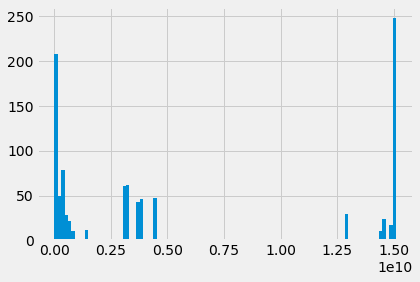

In [55]:
train_df['timestamp'].hist(bins = 100)

In [56]:
grouped_by_user_df = train_df.groupby('user_id')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1cc37cf8>]],
      dtype=object)

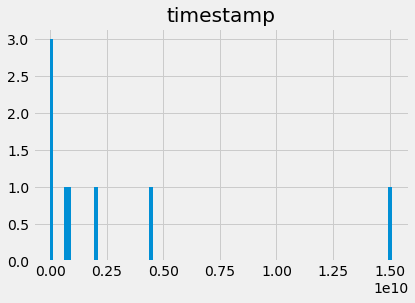

In [57]:
grouped_by_user_df.agg({'timestamp': 'max'}).hist(bins = 100)

# Baseline


In [58]:
train_df = pd.read_csv(train_csv)

train_df["prior_question_had_explanation"].apply(bool)

0             True
1            False
2            False
3            False
4            False
5            False
6            False
7            False
8            False
9            False
10           False
11           False
12           False
13           False
14           False
15           False
16           False
17           False
18           False
19           False
20           False
21           False
22           False
23           False
24           False
25           False
26           False
27           False
28           False
29           False
             ...  
101230302     True
101230303     True
101230304     True
101230305     True
101230306    False
101230307    False
101230308    False
101230309    False
101230310    False
101230311    False
101230312    False
101230313     True
101230314     True
101230315     True
101230316     True
101230317     True
101230318     True
101230319     True
101230320     True
101230321     True
101230322     True
101230323   

In [59]:
features_part_df = train_df.iloc[:int(9/10 * len(train_df))]
train_part_df = train_df.iloc[int(9/10 * len(train_df)):]

In [60]:
train_questions_only_df = features_part_df[features_part_df['answered_correctly']!=-1]
# 过滤掉那些answered_correctly为-1的行，也就是是lecture的行
grouped_by_user_df = train_questions_only_df.groupby('user_id')
# 按照user_id，将相同user_id的行合并在一组


In [61]:
user_answers_df = grouped_by_user_df.agg({'answered_correctly':['mean','count']}).copy()
#聚合操作，对每一个用户计算他答对的均值mean，以及count指非NaN值的数目(NaN指的是那些lecture的题，它的answered_correctly为NaN)
user_answers_df

answered_correctly      
                         mean count
user_id                            
115                  0.695652    46
124                  0.233333    30
2746                 0.578947    19
5382                 0.672000   125
8623                 0.642202   109
8701                 0.588235    17
12741                0.573585   265
13134                0.706356  1243
24418                0.690275  6283
24600                0.340000    50
32421                0.466667    30
40828                0.630435    92
44331                0.587629   291
45001                0.233333    30
46886                0.613636    44
50132                0.621622    74
51285                0.545455    22
53842                0.233333    30
81002                0.529412    17
81429                0.466667    30
91216                0.663415  1845
99521                0.814815    27
107002               0.823133  1928
108310               0.756757    37
128919               0.333333    30
137455               0.340000    50
138650               0.713628  1086
140969               0.450000    40
141455               0.691832  2265
142896               0.307692    13
...                       ...   ...
1933608435           0.822785    79
1933613016           0.564626   147
1933621554           0.617021    94
1933623444           0.650000    40
1933623505           0.840000   100
1933625442           0.684466   412
1933632432           0.500000    16
1933639354           0.166667    12
1933648276           0.730769    26
1933652464           0.600000    55
1933653197           0.673913    92
1933653539           0.300000    30
1933656070           0.666667    33
1933659107           0.468085    47
1933663906           0.722222    18
1933669605           0.833333   108
1933670429           0.764706    17
1933670662           0.685106   235
1933671833           0.662234   376
1933674471           0.466667    30
1933678689           0.600000    40
1933688162           0.764706    34
1933692937           0.550459   109
1933694491           0.740741    27
1933697874           0.380952    21
1933700710           0.624829  1466
1933703805           0.650000    40
1933711038           0.684211    38
1933715576           0.375000    16
1933715875           0.779843  5219

[354308 rows x 2 columns]

In [63]:
user_answers_df.columns = ['mean_user_accuracy', 'questions_answered']
user_answers_df

,mean_user_accuracy,questions_answered
user_id,,
115,0.695652,46
124,0.233333,30
2746,0.578947,19
5382,0.672000,125
8623,0.642202,109
8701,0.588235,17
12741,0.573585,265
13134,0.706356,1243
24418,0.690275,6283


In [65]:
grouped_by_content_df = train_questions_only_df.groupby('content_id')
# 按照content_id对数据进行聚合，对应着question.csv里面的question_id 和lectures.csv里面的lecture_id
content_answers_df = grouped_by_content_df.agg({'answered_correctly':['mean','count']}).copy()
content_answers_df

answered_correctly       
                         mean  count
content_id                          
0                    0.908595   6236
1                    0.891682   6684
2                    0.554656  40499
3                    0.779348  20734
4                    0.613226  28549
5                    0.862711   8748
6                    0.474880  51074
7                    0.867110  14892
8                    0.906234   7700
9                    0.305511  42591
10                   0.682652  28004
11                   0.887065   6092
12                   0.760853  18336
13                   0.886931   8172
14                   0.799854  13675
15                   0.706806  18336
16                   0.424746   4930
17                   0.869639   7671
18                   0.828825  18893
19                   0.826866  10102
20                   0.974467   4269
21                   0.752118  10267
22                   0.862679   6838
23                   0.734938   7519
24                   0.657802  15266
25                   0.783139  19192
26                   0.820510   8162
27                   0.664748  10252
28                   0.645283  18581
29                   0.493949   4462
...                       ...    ...
13493                0.625899    834
13494                0.820606    825
13495                0.829865    817
13496                0.783784    777
13497                0.673548    775
13498                0.594660    824
13499                0.892500    800
13500                0.841907    797
13501                0.736495    759
13502                0.268638    778
13503                0.434099    827
13504                0.702469    810
13505                0.794228    797
13506                0.930446    762
13507                0.846054    773
13508                0.574966    727
13509                0.805764    798
13510                0.881333    750
13511                0.381797    846
13512                0.685542    830
13513                0.684547    783
13514                0.541284    763
13515                0.653367    802
13516                0.582390    795
13517                0.826667    825
13518                0.789203    778
13519                0.567797    826
13520                0.678524    759
13521                0.822560    789
13522                0.914174    769

[13519 rows x 2 columns]

In [66]:
content_answers_df.columns = ['mean_accuracy','question_asked']

## 创造一些额外的feature

In [70]:
questions_df = pd.read_csv(que_csv)
questions_df

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38
5,5,5,2,1,131 149 162 81
6,6,6,2,1,10 94 162 92
7,7,7,0,1,61 110 162 29
8,8,8,3,1,131 13 162 92
9,9,9,3,1,10 164 81


In [71]:
questions_df = questions_df.merge(content_answers_df, left_on= 'question_id', right_on='content_id',how='left')
questions_df

,question_id,bundle_id,correct_answer,part,tags,mean_accuracy,question_asked
0,0,0,0,1,51 131 162 38,0.908595,6236.0
1,1,1,1,1,131 36 81,0.891682,6684.0
2,2,2,0,1,131 101 162 92,0.554656,40499.0
3,3,3,0,1,131 149 162 29,0.779348,20734.0
4,4,4,3,1,131 5 162 38,0.613226,28549.0
5,5,5,2,1,131 149 162 81,0.862711,8748.0
6,6,6,2,1,10 94 162 92,0.474880,51074.0
7,7,7,0,1,61 110 162 29,0.867110,14892.0
8,8,8,3,1,131 13 162 92,0.906234,7700.0
9,9,9,3,1,10 164 81,0.305511,42591.0


In [73]:
bundle_dict = questions_df['bundle_id'].value_counts().to_dict()
# bundle_id指的是当前question属于哪个bundle,也就是属于哪一类一起的
# 这行代码的主要作用是，查看总共有多少类bundle_id【dict里面的key】，并且每个bundle_id出现的次数【dict里面的value】
# 这里其实不是很清楚执行的结果是否正确，因为看前面的questions_df，每个question_id对应一个bundle_id
bundle_dict

{7795: 5,
 6971: 5,
 7421: 5,
 7770: 5,
 8144: 5,
 7504: 5,
 7749: 5,
 7153: 5,
 6976: 5,
 7401: 5,
 7714: 5,
 7780: 5,
 7704: 5,
 7001: 5,
 7085: 5,
 8074: 5,
 7396: 5,
 11868: 5,
 7775: 5,
 8029: 5,
 7744: 5,
 7499: 5,
 8034: 5,
 7724: 5,
 6940: 5,
 7270: 5,
 7006: 5,
 7366: 5,
 7168: 5,
 6986: 5,
 11689: 5,
 11863: 5,
 8079: 5,
 8089: 5,
 7785: 5,
 7489: 5,
 6966: 5,
 7709: 5,
 7195: 5,
 6981: 5,
 7045: 5,
 8129: 5,
 8154: 5,
 7664: 5,
 8114: 5,
 8159: 5,
 8149: 5,
 7265: 5,
 11552: 5,
 8094: 5,
 8024: 5,
 8109: 5,
 7411: 5,
 7356: 5,
 8064: 5,
 8104: 5,
 11684: 5,
 7145: 5,
 7406: 5,
 8119: 5,
 7734: 5,
 7190: 5,
 7659: 5,
 7494: 5,
 7426: 5,
 7260: 5,
 7699: 5,
 7790: 5,
 8069: 5,
 7719: 5,
 11575: 5,
 7381: 5,
 7371: 5,
 7689: 5,
 7326: 5,
 7361: 5,
 6991: 5,
 7376: 5,
 7341: 5,
 8084: 5,
 7391: 5,
 7431: 5,
 8019: 5,
 8139: 5,
 11679: 5,
 8039: 5,
 7095: 5,
 7331: 5,
 6996: 5,
 7173: 5,
 8049: 5,
 6961: 5,
 7416: 5,
 7100: 5,
 8014: 5,
 8099: 5,
 7336: 5,
 8124: 5,
 7729: 5,
 76

In [74]:
questions_df["right_answers"] = questions_df["mean_accuracy"] * questions_df["question_asked"]
# 这个是用每个问题的回答的准确率mean_accuracy，去乘以每个问题被问的数目question_asked，最后得到回答正确的数目right_answers

In [76]:
questions_df["bundle_size"] = questions_df["bundle_id"].apply(lambda x: bundle_dict[x])
# 这个主要是将每个bundle_id对应的那个bundle的大小去bundle_dict中得到,但是其实都是1

In [77]:
questions_df

,question_id,bundle_id,correct_answer,part,tags,mean_accuracy,question_asked,right_answers,bundle_size
0,0,0,0,1,51 131 162 38,0.908595,6236.0,5666.0,1
1,1,1,1,1,131 36 81,0.891682,6684.0,5960.0,1
2,2,2,0,1,131 101 162 92,0.554656,40499.0,22463.0,1
3,3,3,0,1,131 149 162 29,0.779348,20734.0,16159.0,1
4,4,4,3,1,131 5 162 38,0.613226,28549.0,17507.0,1
5,5,5,2,1,131 149 162 81,0.862711,8748.0,7547.0,1
6,6,6,2,1,10 94 162 92,0.474880,51074.0,24254.0,1
7,7,7,0,1,61 110 162 29,0.867110,14892.0,12913.0,1
8,8,8,3,1,131 13 162 92,0.906234,7700.0,6978.0,1
9,9,9,3,1,10 164 81,0.305511,42591.0,13012.0,1


In [78]:
grouped_by_bundle_df = questions_df.groupby('bundle_id')
# 按照bundle_id对questions_df进行聚合

In [79]:
bundle_answers_df = grouped_by_bundle_df.agg({'right_answers':'sum', 'question_asked':'sum'}).copy()

In [80]:
bundle_answers_df.columns = ['bundle_right_answers', 'bundle_questions_asked']

In [81]:
bundle_answers_df['bundle_accuracy'] = bundle_answers_df['bundle_right_answers']/bundle_answers_df['bundle_questions_asked']

In [82]:
bundle_answers_df

,bundle_right_answers,bundle_questions_asked,bundle_accuracy
bundle_id,,,
0,5666.0,6236.0,0.908595
1,5960.0,6684.0,0.891682
2,22463.0,40499.0,0.554656
3,16159.0,20734.0,0.779348
4,17507.0,28549.0,0.613226
5,7547.0,8748.0,0.862711
6,24254.0,51074.0,0.474880
7,12913.0,14892.0,0.867110
8,6978.0,7700.0,0.906234


In [83]:
grouped_by_part_df = questions_df.groupby('part')
# part是指 the relevant section of the TOEIC test.
part_answers_df = grouped_by_part_df.agg({'right_answers':'sum', 'question_asked':'sum'}).copy()
part_answers_df.columns = ['part_right_answers','part_questions_asked']
part_answers_df['part_accuracy'] = part_answers_df['part_right_answers'] / part_answers_df['part_questions_asked']
part_answers_df

,part_right_answers,part_questions_asked,part_accuracy
part,,,
1,5014431.0,6726438.0,0.745481
2,11966709.0,16884487.0,0.708740
3,5449615.0,7763910.0,0.701916
4,4587947.0,7270010.0,0.631078
5,22459316.0,36815816.0,0.610045
6,6320212.0,9442385.0,0.669345
7,2930791.0,4441303.0,0.659894


In [84]:
features = ['timestamp','mean_user_accuracy','questions_answered','mean_accuracy','question_asked',
           'prior_question_elapsed_time','prior_question_had_explanation','bundle_size',
           'bundle_accuracy','part_accuracy','right_answers']

target = 'answered_correctly'

train_part_df = train_part_df[train_part_df[target] != -1]
# 将那些训练数据中answered_correctly的值为-1的，也就是是lecture的值去掉


In [85]:
train_part_df

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
91107298,91107298,8231964660,1933715875,11259,0,3188,2,0,13000.0,True
91107299,91107299,8232002976,1933715875,4957,0,3189,2,1,44000.0,True
91107300,91107300,8232096407,1933715875,5113,0,3190,0,1,22000.0,True
91107301,91107301,8232119872,1933715875,4699,0,3191,1,1,74000.0,True
91107302,91107302,8232142930,1933715875,11430,0,3192,3,1,9000.0,True
91107303,91107303,8232271384,1933715875,8217,0,3193,2,0,13000.0,True
91107304,91107304,8232333990,1933715875,5293,0,3194,3,1,88000.0,True
91107305,91107305,8232357667,1933715875,3840,0,3195,0,1,21000.0,True
91107306,91107306,8232374283,1933715875,11436,0,3196,1,1,14000.0,True
91107307,91107307,8232435220,1933715875,5353,0,3197,1,0,7000.0,True


In [86]:
user_answers_df

,mean_user_accuracy,questions_answered
user_id,,
115,0.695652,46
124,0.233333,30
2746,0.578947,19
5382,0.672000,125
8623,0.642202,109
8701,0.588235,17
12741,0.573585,265
13134,0.706356,1243
24418,0.690275,6283


In [87]:
train_part_df = train_part_df.merge(user_answers_df, how='left', on='user_id')
train_part_df

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,mean_user_accuracy,questions_answered
0,91107298,8231964660,1933715875,11259,0,3188,2,0,13000.0,True,0.779843,5219.0
1,91107299,8232002976,1933715875,4957,0,3189,2,1,44000.0,True,0.779843,5219.0
2,91107300,8232096407,1933715875,5113,0,3190,0,1,22000.0,True,0.779843,5219.0
3,91107301,8232119872,1933715875,4699,0,3191,1,1,74000.0,True,0.779843,5219.0
4,91107302,8232142930,1933715875,11430,0,3192,3,1,9000.0,True,0.779843,5219.0
5,91107303,8232271384,1933715875,8217,0,3193,2,0,13000.0,True,0.779843,5219.0
6,91107304,8232333990,1933715875,5293,0,3194,3,1,88000.0,True,0.779843,5219.0
7,91107305,8232357667,1933715875,3840,0,3195,0,1,21000.0,True,0.779843,5219.0
8,91107306,8232374283,1933715875,11436,0,3196,1,1,14000.0,True,0.779843,5219.0
9,91107307,8232435220,1933715875,5353,0,3197,1,0,7000.0,True,0.779843,5219.0


In [88]:
train_part_df = train_part_df.merge(questions_df, how='left', left_on='content_id', right_on='question_id')

In [89]:
train_part_df = train_part_df.merge(bundle_answers_df, how='left', on='bundle_id')

In [90]:
train_part_df = train_part_df.merge(part_answers_df, how='left', on='part')

In [91]:
train_part_df['prior_question_had_explanation'] = train_part_df['prior_question_had_explanation'].fillna(value = False).astype(bool)


In [92]:
train_part_df.fillna(value=-1, inplace=True)
# 将NaN的值设置为-1， inplace表示是直接在原数据对象上进行修改

In [93]:
train_part_df.columns

Index(['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
       'task_container_id', 'user_answer', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_question_had_explanation',
       'mean_user_accuracy', 'questions_answered', 'question_id', 'bundle_id',
       'correct_answer', 'part', 'tags', 'mean_accuracy', 'question_asked',
       'right_answers', 'bundle_size', 'bundle_right_answers',
       'bundle_questions_asked', 'bundle_accuracy', 'part_right_answers',
       'part_questions_asked', 'part_accuracy'],
      dtype='object')

In [94]:
train_part_df

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,...,mean_accuracy,question_asked,right_answers,bundle_size,bundle_right_answers,bundle_questions_asked,bundle_accuracy,part_right_answers,part_questions_asked,part_accuracy
0,91107298,8231964660,1933715875,11259,0,3188,2,0,13000.0,True,...,0.532146,1291.0,687.0,1,687.0,1291.0,0.532146,22459316.0,36815816.0,0.610045
1,91107299,8232002976,1933715875,4957,0,3189,2,1,44000.0,True,...,0.584772,2548.0,1490.0,1,1490.0,2548.0,0.584772,22459316.0,36815816.0,0.610045
2,91107300,8232096407,1933715875,5113,0,3190,0,1,22000.0,True,...,0.603571,1960.0,1183.0,1,1183.0,1960.0,0.603571,22459316.0,36815816.0,0.610045
3,91107301,8232119872,1933715875,4699,0,3191,1,1,74000.0,True,...,0.694888,2504.0,1740.0,1,1740.0,2504.0,0.694888,22459316.0,36815816.0,0.610045
4,91107302,8232142930,1933715875,11430,0,3192,3,1,9000.0,True,...,0.765869,1922.0,1472.0,1,1472.0,1922.0,0.765869,22459316.0,36815816.0,0.610045
5,91107303,8232271384,1933715875,8217,0,3193,2,0,13000.0,True,...,0.604843,1817.0,1099.0,1,1099.0,1817.0,0.604843,22459316.0,36815816.0,0.610045
6,91107304,8232333990,1933715875,5293,0,3194,3,1,88000.0,True,...,0.670170,2474.0,1658.0,1,1658.0,2474.0,0.670170,22459316.0,36815816.0,0.610045
7,91107305,8232357667,1933715875,3840,0,3195,0,1,21000.0,True,...,0.586366,2171.0,1273.0,1,1273.0,2171.0,0.586366,22459316.0,36815816.0,0.610045
8,91107306,8232374283,1933715875,11436,0,3196,1,1,14000.0,True,...,0.922289,1171.0,1080.0,1,1080.0,1171.0,0.922289,22459316.0,36815816.0,0.610045
9,91107307,8232435220,1933715875,5353,0,3197,1,0,7000.0,True,...,0.529950,4040.0,2141.0,1,2141.0,4040.0,0.529950,22459316.0,36815816.0,0.610045


In [96]:
train_part_df = train_part_df[features + [target]]
train_part_df

,timestamp,mean_user_accuracy,questions_answered,mean_accuracy,question_asked,prior_question_elapsed_time,prior_question_had_explanation,bundle_size,bundle_accuracy,part_accuracy,right_answers,answered_correctly
0,8231964660,0.779843,5219.0,0.532146,1291.0,13000.0,True,1,0.532146,0.610045,687.0,0
1,8232002976,0.779843,5219.0,0.584772,2548.0,44000.0,True,1,0.584772,0.610045,1490.0,1
2,8232096407,0.779843,5219.0,0.603571,1960.0,22000.0,True,1,0.603571,0.610045,1183.0,1
3,8232119872,0.779843,5219.0,0.694888,2504.0,74000.0,True,1,0.694888,0.610045,1740.0,1
4,8232142930,0.779843,5219.0,0.765869,1922.0,9000.0,True,1,0.765869,0.610045,1472.0,1
5,8232271384,0.779843,5219.0,0.604843,1817.0,13000.0,True,1,0.604843,0.610045,1099.0,0
6,8232333990,0.779843,5219.0,0.670170,2474.0,88000.0,True,1,0.670170,0.610045,1658.0,1
7,8232357667,0.779843,5219.0,0.586366,2171.0,21000.0,True,1,0.586366,0.610045,1273.0,1
8,8232374283,0.779843,5219.0,0.922289,1171.0,14000.0,True,1,0.922289,0.610045,1080.0,1
9,8232435220,0.779843,5219.0,0.529950,4040.0,7000.0,True,1,0.529950,0.610045,2141.0,0


# 训练模型

In [97]:
import sklearn

In [99]:
from sklearn.metrics import roc_auc_score
